## Data Overview

Check the competition: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import pydicom
from glob import glob
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')
from mask_functions import rle2mask, mask2rle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate
import cv2

## Load Data

In [2]:
# Load rles
train_csv_dir = '../input/siim-acr-pneumothorax-segmentation/stage_2_train.csv'
rles_df = pd.read_csv(train_csv_dir)
# Create a dic for images with masks
rles_df = rles_df[rles_df['EncodedPixels']!='-1'].groupby('ImageId')['EncodedPixels']\
            .apply(list).reset_index()
masks = {}
for index, row in rles_df.iterrows():
    masks[row['ImageId']] = row['EncodedPixels']

# Create a list of image files
train_stage1_fns = sorted(glob('../input/siim-train-test/siim/dicom-images-train/*/*/*.dcm'))
test_stage1_fns = sorted(glob('../input/siim-train-test/siim/dicom-images-test/*/*/*.dcm'))
train_file_path = train_stage1_fns+test_stage1_fns

## Build Model

We are implementing a UNet model

In [3]:
# Parameters
img_size = 128
batch_size = 32
k_size = 3
train_size = 0.2
test_size = 0.05
shuffle = True
channels = 1
epoch = 2
smooth = 1 
verbose = 2  

In [4]:
# Define a data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path_list, labels, batch_size=32, img_size=256, channels=1, shuffle=True):
        self.file_path_list = file_path_list
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.file_path_list)) / self.batch_size)

    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        file_path_list_temp = [self.file_path_list[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(file_path_list_temp)
        # return data 
        return X, y

    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.file_path_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, file_path_list_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_size, self.img_size, self.channels))
        y = np.empty((self.batch_size, self.img_size, self.img_size, self.channels))

        for idx, file_path in enumerate(file_path_list_temp):

            id = file_path.split('/')[-1][:-4]
            rle = self.labels.get(id)
            image = pydicom.read_file(file_path).pixel_array
            image_resized = cv2.resize(image, (self.img_size, self.img_size))
            image_resized = np.array(image_resized, dtype=np.float64)

            X[idx,] = np.expand_dims(image_resized, axis=2)

            # if there is no mask create empty mask
            # notice we are starting of with 1024 because we need to use the rle2mask function
            
            mask = np.zeros((1024, 1024))
            if rle is not None:
                for r in rle:
                    mask =  mask + rle2mask(r, 1024, 1024).T

            mask_resized = cv2.resize(mask, (self.img_size, self.img_size))
            y[idx,] = np.expand_dims(mask_resized, axis=2)

        # normalize 
        X = X / 255
        y = y / 255

        return X, y

In [5]:
# Create generators for training and validating
params = {'img_size': img_size,
          'batch_size': batch_size,
          'channels': channels,
          'shuffle': shuffle}

X_train,X_val = train_test_split(train_file_path,train_size=train_size ,test_size=test_size)

train_gen = DataGenerator(X_train,masks,**params)
val_gen = DataGenerator(X_val,masks,**params)

(32, 128, 128, 1) (32, 128, 128, 1)


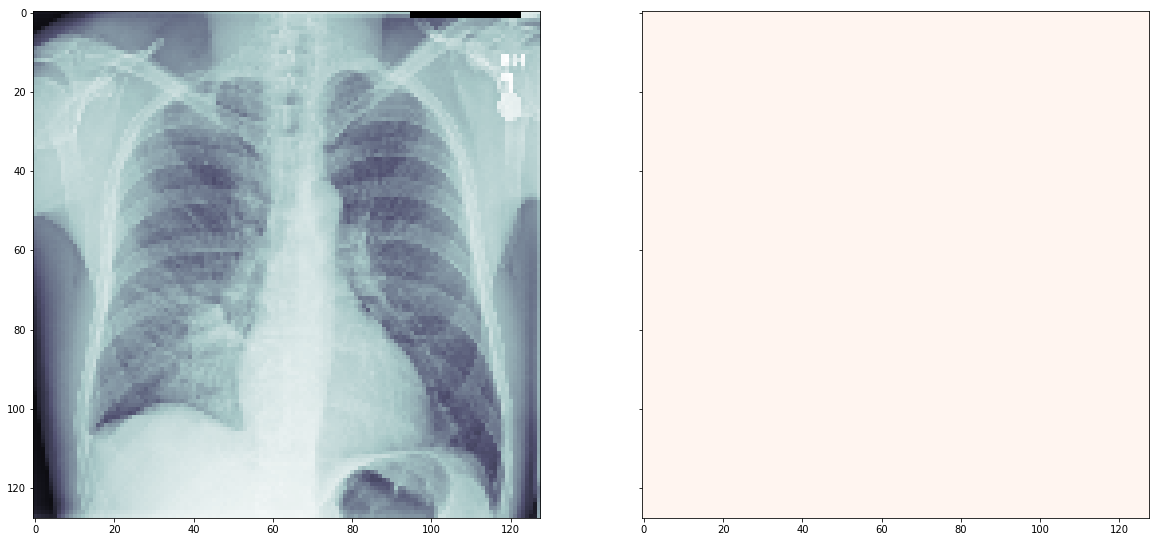

In [6]:
# Sample batch
x, y = train_gen.__getitem__(1)
print(x.shape, y.shape)
n=8
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
ax[0].imshow(x[n,:,:,0],cmap='bone')
ax[1].imshow(y[n,:,:,0],cmap='Reds')

In [7]:
# Helper functions
def down_block(x, filters, kernel_size=3, padding='same', strides=1, activation='relu'):
    'down sampling block of our UNet'
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
    pool = MaxPool2D((2,2), (2,2))(conv)
    return conv, pool

def up_block(x, skip, filters, kernel_size=3, padding='same', strides=1, activation='relu'):
    'up sampling block of our UNet'
    up_sample = UpSampling2D((2,2))(x)
    concat = Concatenate()([up_sample, skip])
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(concat)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
    return conv

def bottleneck(x, filters, kernel_size=3, padding='same', strides=1, activation='relu'):
    'bottle neck that sits inbetween the down sampling side and the up sampling side'
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
    return conv

def UNet(img_size):
    'constructing UNet using the blocks defined above'
    
    # number of filters per block
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_size, img_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])
    
    outputs = Conv2D(1, (1,1), padding='same', activation='sigmoid')(u4)
    model = Model(inputs, outputs)
    return model

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [8]:
model = UNet(img_size)
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
history = model.fit_generator(generator=train_gen, validation_data=val_gen, epochs=epoch, verbose=verbose)

Epoch 1/2


KeyboardInterrupt: 